In [1]:
%run 'Data Cleaning'.ipynb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [2]:
import seaborn as sb
import matplotlib.pyplot as plt

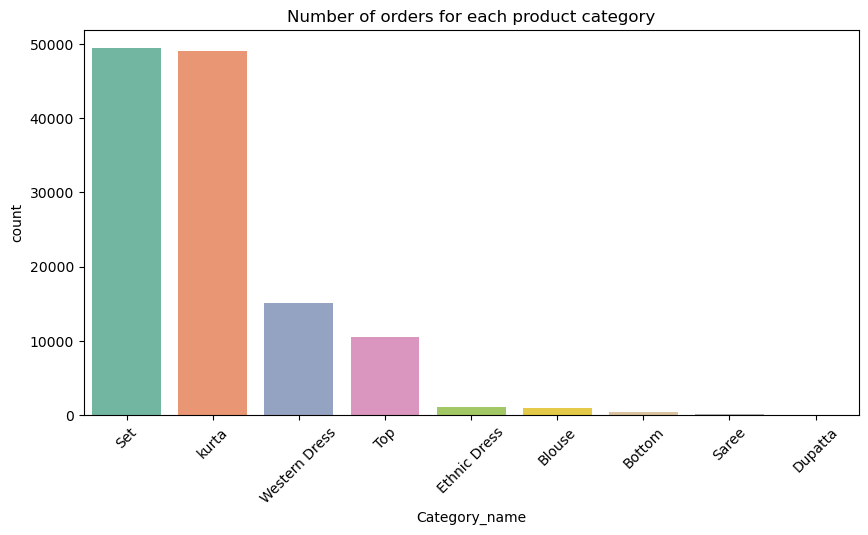

In [3]:
# Bar chart showing the number of orders per product category
plt.figure(figsize=(10,5))
sb.countplot(x='Category_name', data=df, order=df["Category_name"].value_counts().index, palette="Set2")
plt.xticks(rotation=45)
plt.title('Number of orders for each product category')
plt.show()

- The majority of orders come from just two categories: Set and Kurta, each with nearly 50,000 orders.
- Western Dress and Top follow, but with significantly fewer orders — around 15,000 and 10,000 respectively.
- The remaining categories (e.g., Ethnic Dress, Blouse, Bottom, Saree, Dupatta) have very low order counts, suggesting they are either niche products or underrepresented in the dataset.
- The overall distribution is highly imbalanced, with a long tail of low-frequency categories.
- To ensure model stability and avoid overfitting on small categories, we decided to limit our analysis and model training to the top 4 product categories.

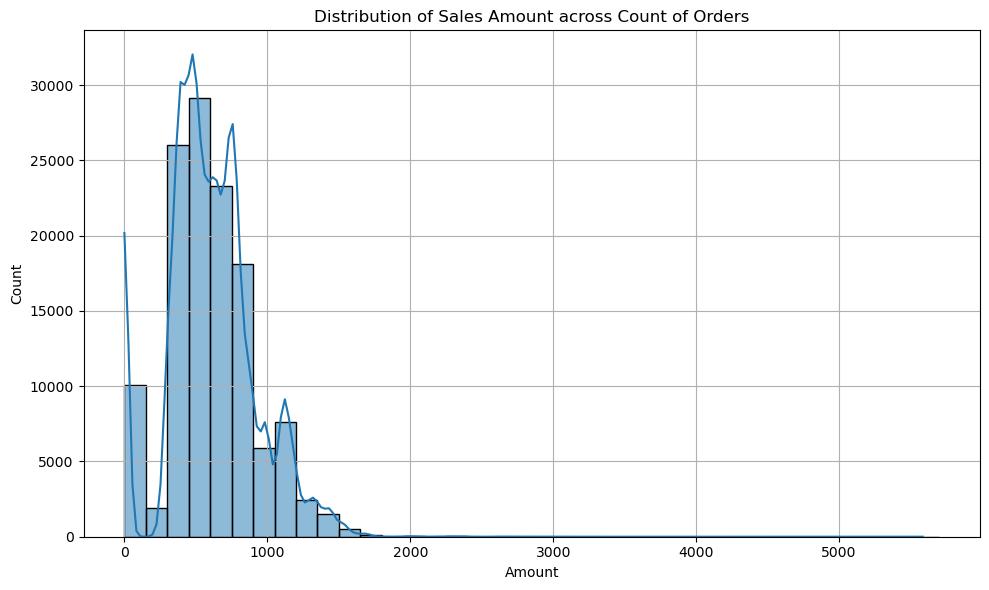

In [5]:
# Histogram with KDE curve to visualize the distribution of order amounts
fig, my_ax = plt.subplots(figsize=(10,6))

sb.histplot(data = df['Amount'], ax=my_ax, binwidth=150, kde=True)
plt.grid(True)
plt.title("Distribution of Sales Amount across Count of Orders")
plt.tight_layout()

- This histogram shows the distribution of order amounts across all transactions.
- The distribution is right-skewed, meaning most orders fall within the ₹300 to ₹1000 range, while a smaller number of high-value orders extend into the ₹2000–₹5000+ range.
- There is a long tail of high-value orders, but they are relatively rare.
- A noticeable spike around ₹0–₹100 may indicate free samples, returns, or data noise.
- It also implies that order amount alone may not be a strong predictor of cancellation, and should be used alongside other features.

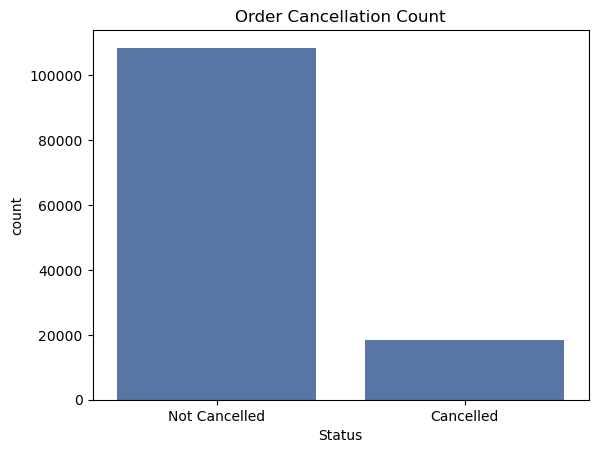

Status
0    85.55%
1    14.45%
Name: proportion, dtype: object


In [7]:
# Count of Cancelled vs Not Cancelled orders
sb.countplot(data=df, x="Status", color="#4C72B0")
plt.title("Order Cancellation Count")
plt.xticks([0,1], ["Not Cancelled", "Cancelled"])
plt.show()

# View as percentage
print(df["Status"].value_counts(normalize=True).map("{:.2%}".format))

- This bar chart shows the distribution of orders based on their status: Cancelled vs Not Cancelled.
- Out of all orders, the vast majority — around 86% — were successfully fulfilled and not cancelled.
- Only about 14% of orders were cancelled.
- Without proper handling, such imbalance may cause the model to favor the majority class (Not Cancelled) and perform poorly on the minority class (Cancelled).
- Models should be evaluated using recall, precision, or F1-score, and techniques such as class weighting should be considered.

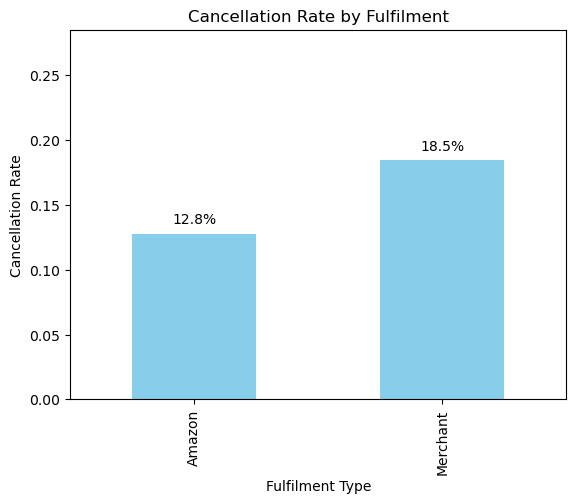

In [9]:
# Fulfilment vs Cancellation Rate
cancel_rate = df.groupby("Fulfilment")["Status"].mean()
cancel_rate.index = cancel_rate.index.map({0: "Amazon", 1: "Merchant"})

cancel_rate.plot(kind="bar", color="skyblue")
plt.title("Cancellation Rate by Fulfilment")
plt.ylabel("Cancellation Rate")
plt.xlabel("Fulfilment Type")
plt.ylim(0, cancel_rate.max() + 0.1)

for i, v in enumerate(cancel_rate):
    plt.text(i, v + 0.005, f"{v:.1%}", ha='center', va='bottom', fontsize=10)

plt.show()

- This chart compares the cancellation rates between orders fulfilled by Amazon versus third-party merchants.
- Orders fulfilled by Amazon have a lower cancellation rate of 12.8%, while those fulfilled by Merchants face a significantly higher rate of 18.5%.
- This suggests that fulfilment type plays an important role in order reliability.
- Amazon’s in-house fulfilment may offer better logistics and customer service, leading to fewer cancellations.
- Therefore, Fulfilment is likely to be a strong predictive feature for our model.

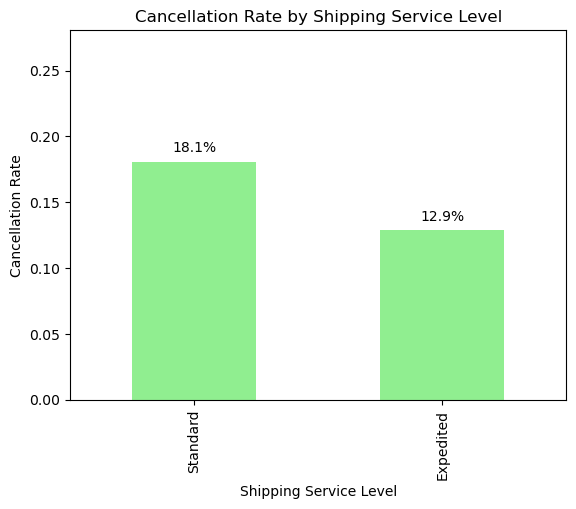

In [11]:
# Ship-service-level vs Cancellation Rate
cancel_rate = df.groupby("ship-service-level")["Status"].mean()
cancel_rate.index = cancel_rate.index.map({0: "Standard", 1: "Expedited"})

cancel_rate.plot(kind="bar", color="lightgreen")
plt.title("Cancellation Rate by Shipping Service Level")
plt.ylabel("Cancellation Rate")
plt.xlabel("Shipping Service Level")
plt.ylim(0, cancel_rate.max() + 0.1)

for i, v in enumerate(cancel_rate):
    plt.text(i, v + 0.005, f"{v:.1%}", ha='center', va='bottom', fontsize=10)

plt.show()

- This chart compares the cancellation rates between Standard and Expedited shipping services.
- Orders with Standard shipping have a higher cancellation rate of 18.1%, while those with Expedited shipping have a lower rate of 12.9%.
- This suggests that customers opting for faster delivery are less likely to cancel their orders.
- One possible reason is that expedited shipping improves customer satisfaction by reducing waiting time.
- Therefore, Shipping Service Level is a meaningful feature to include in our prediction model.

  Promotion Type  Order_Count  Cancelled_Count
0       No Promo        49149            18037
1  Free Shipping        46198              294
2           PLCC        30202                0
3          Other         1276                1


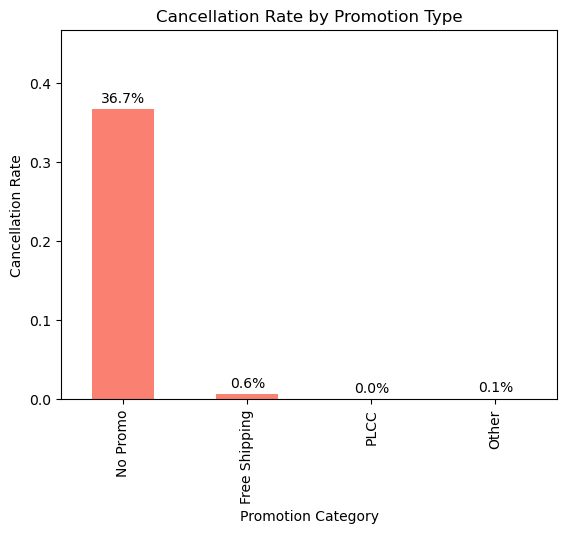

In [13]:
# Promotion Type vs Cancellation Rate
# Calculate total order count and number of cancelled orders for each promotion category
promo_summary = df.groupby("promotion-ids")["Status"].agg(
    Order_Count='count',
    Cancelled_Count='sum'
).reset_index()

promo_summary["Promotion Type"] = promo_summary["promotion-ids"].map({
    0: "No Promo", 
    1: "Free Shipping", 
    2: "PLCC", 
    3: "Other"
})

promo_summary = promo_summary[["Promotion Type", "Order_Count", "Cancelled_Count"]]
print(promo_summary)

cancel_rate = df.groupby("promotion-ids")["Status"].mean()
cancel_rate.index = cancel_rate.index.map({
    0: "No Promo", 
    1: "Free Shipping", 
    2: "PLCC", 
    3: "Other"
})

cancel_rate.plot(kind="bar", color="salmon")
plt.title("Cancellation Rate by Promotion Type")
plt.ylabel("Cancellation Rate")
plt.xlabel("Promotion Category")
plt.ylim(0, cancel_rate.max() + 0.1)

for i, v in enumerate(cancel_rate):
    plt.text(i, v + 0.005, f"{v:.1%}", ha='center', va='bottom', fontsize=10)

plt.show()

- This chart compares the cancellation rate across four types of promotions: No Promo, Free Shipping, PLCC, and Other.
- Orders without any promotion have a very high cancellation rate of 36.7%.
- In contrast, orders with Free Shipping, PLCC, or Other promotions have extremely low cancellation rates (under 1%).
- This suggests that promotions play a significant role in customer commitment and follow-through.
- Therefore, Promotion Type is one of the strongest predictors in our dataset and should be emphasized in modeling.

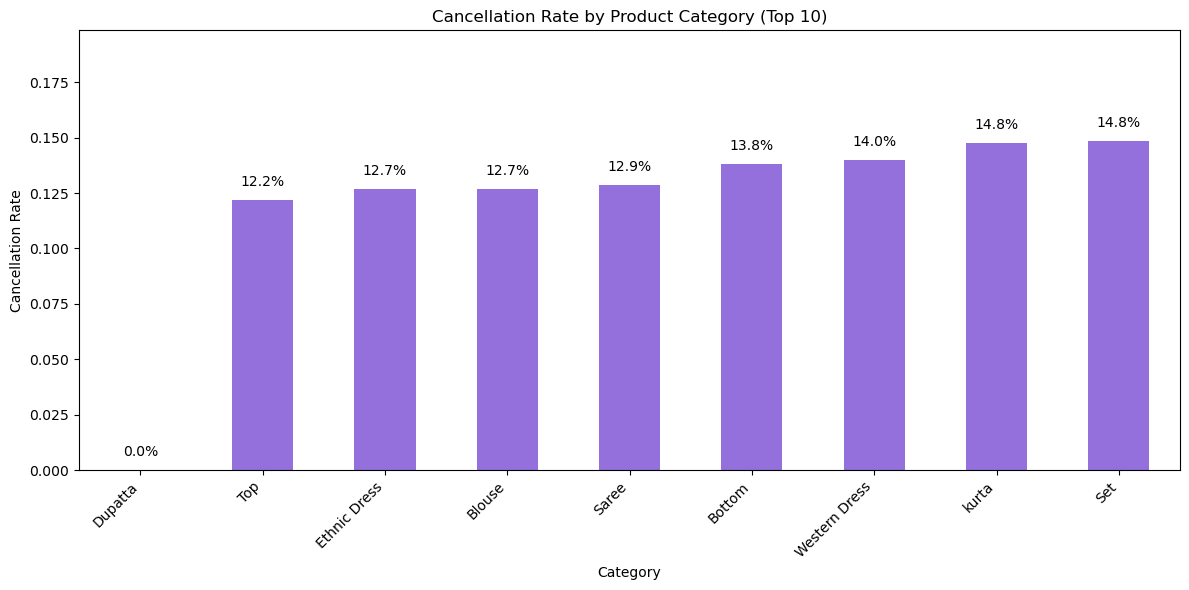

In [15]:
# Product Category (Top 10) vs Cancellation Rate
cancel_rate = df.groupby("Category_name")["Status"].mean().sort_values()

plt.figure(figsize=(12, 6))
cancel_rate.plot(kind="bar", color="mediumpurple")
plt.title("Cancellation Rate by Product Category (Top 10)")
plt.ylabel("Cancellation Rate")
plt.xlabel("Category")
plt.ylim(0, cancel_rate.max() + 0.05)

for i, v in enumerate(cancel_rate):
    plt.text(i, v + 0.005, f"{v:.1%}", ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- This bar chart displays the cancellation rates across the top 10 product categories by order volume.
- While cancellation rates range from 12.2% to 14.8% for most categories, both "Kurta" and "Set" show the highest cancellation rate at 14.8%.
- These two categories also have the highest order volumes, making them especially important to monitor.
- Categories like "Top", "Blouse", and "Ethnic Dress" have slightly lower cancellation rates (~12%).
- The variation in cancellation rates across product categories suggests that product type may influence customer cancellation behavior and could contribute meaningfully to prediction models.

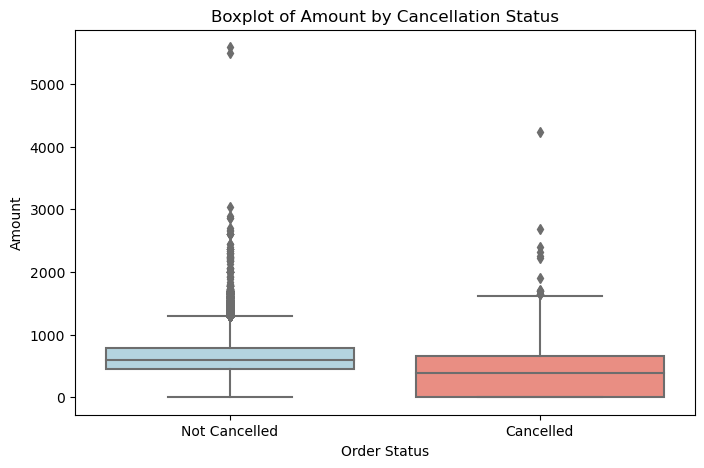

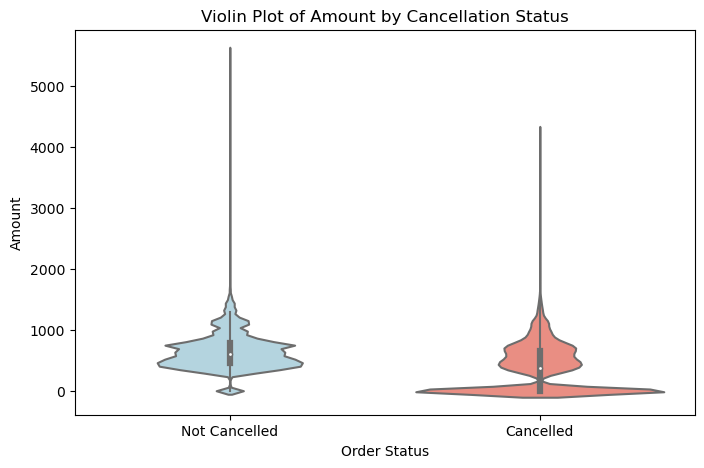

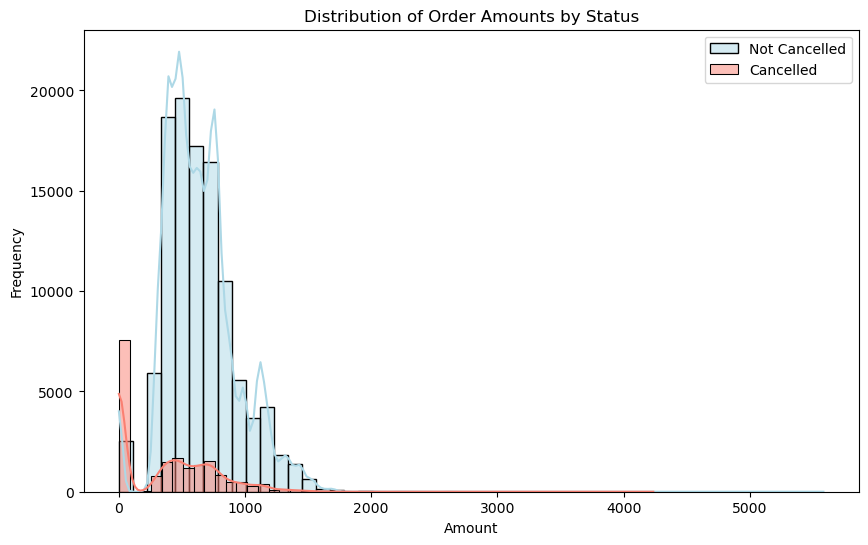

In [17]:
# Amount vs Cancellation
plt.figure(figsize=(8, 5))
sb.boxplot(data=df, x="Status", y="Amount", palette=["lightblue", "salmon"])
plt.xticks([0, 1], ["Not Cancelled", "Cancelled"])
plt.title("Boxplot of Amount by Cancellation Status")
plt.xlabel("Order Status")
plt.ylabel("Amount")
plt.show()

plt.figure(figsize=(8, 5))
sb.violinplot(data=df, x="Status", y="Amount", palette=["lightblue", "salmon"])
plt.xticks([0, 1], ["Not Cancelled", "Cancelled"])
plt.title("Violin Plot of Amount by Cancellation Status")
plt.xlabel("Order Status")
plt.ylabel("Amount")
plt.show()

plt.figure(figsize=(10, 6))
sb.histplot(data=df[df["Status"] == 0], x="Amount", color="lightblue", label="Not Cancelled", kde=True, bins=50)
sb.histplot(data=df[df["Status"] == 1], x="Amount", color="salmon", label="Cancelled", kde=True, bins=50)
plt.title("Distribution of Order Amounts by Status")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.legend()
plt.show()

- These three plots compare the distribution of order amounts between Cancelled and Not Cancelled orders:
  - A boxplot shows that the median amount for cancelled orders is lower, with more concentration in the lower range.
  - The violin plot reveals a denser cluster of low-value orders among cancellations, and fewer high-value outliers.
  - The histogram with KDE overlay clearly illustrates that cancelled orders tend to have lower order amounts, while not cancelled orders are more spread out and skewed toward higher amounts.
- These patterns suggest that low-value orders are more likely to be cancelled, possibly due to lower buyer commitment or impulse purchases.
- Although the difference is not extreme, order amount still shows a mild predictive signal and should be included in the model, possibly in interaction with other features.

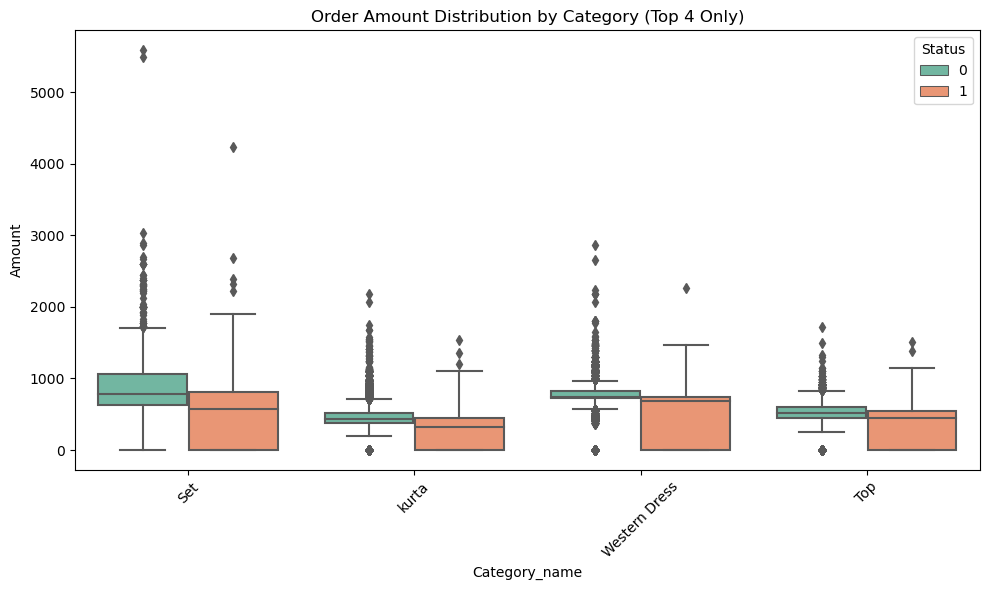

In [19]:
# Comparison of order amount distributions between Cancelled and Not Cancelled orders in the Top 4 product categories
top4_categories = df["Category_name"].value_counts().nlargest(4).index
df_top4 = df[df["Category_name"].isin(top4_categories)]

plt.figure(figsize=(10, 6))
sb.boxplot(data=df_top4, x="Category_name", y="Amount", hue="Status", palette="Set2")
plt.title("Order Amount Distribution by Category (Top 4 Only)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- This boxplot compares the order amount distribution across the top 4 product categories for both Cancelled and Not Cancelled orders.
- In each category — Set, Kurta, Western Dress, and Top — we observe a consistent pattern:
  - Cancelled orders tend to have lower median values than non-cancelled ones.
  - The lower quartile and overall spread of cancelled orders also skews toward the bottom end.
- This suggests that the relationship between order amount and cancellation is not uniform, but may vary across product categories.
- It strengthens the argument that Amount, Category, and Status interact, and this interaction could be valuable for model feature engineering.